In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from state_cleaner import *
import datetime
import csv
from scipy import stats as st
import itertools
import re 
from datetime import datetime

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
os.chdir('../..')
os.chdir('CovidMobile')
os.getcwd()

'C:\\Users\\Noah\\CovidMobile'

In [3]:
def prez_data():
    prez = pd.read_csv("data/countypres_2000-2016.csv")
    prez = prez[prez['year']==2016]
    prez['vote_share'] = prez['candidatevotes'] / prez['totalvotes']
    prez['max'] = prez.groupby(['FIPS','year'])['candidatevotes'].transform(max)
    prez_win = prez[prez['max']==prez['candidatevotes']].copy()
    prez_win = pd.concat([prez_win.reset_index(),prez[prez['party']=='republican']['vote_share'].rename('vote_share_rep').reset_index()],axis=1)
    return prez_win

In [4]:
df = pd.read_csv('data/compiled_2020-05-28.csv')
df.shape

C:\Users\Noah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (103,104,108,111,123,124,125,126,127,128,129,130,131,132,133,135,136,137) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(313403, 149)

In [5]:
df['date'].max()

'2020-05-25'

In [6]:
df.columns.values

array(['Unnamed: 0', 'FIPS', 'date', 'device_count',
       'completely_home_device_count', 'part_time_work_behavior_devices',
       'full_time_work_behavior_devices', 'leaving_home',
       'pct_leaving_home', 'pct_social_distancing', 'county_x', 'state_x',
       'latitude', 'longitude', 'amount_land', 'population',
       'ln_population', 'perc_elderly', 'med_hh_income', 'per_cap_income',
       'perc_white', 'perc_african_american', 'perc_asian',
       'perc_native_american', 'perc_other_race', 'perc_employed',
       'perc_unemployed', 'perc_self_employed_not_own',
       'perc_self_employed_own', 'perc_unpaid_fam_workers',
       'perc_private_employees', 'perc_private_non_profit',
       'perc_govt_workers', 'state_abb_x', 'retail', 'food_drugs', 'park',
       'transit', 'work', 'homes', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018',
       'Births_2018', 'Deaths_2018', 'NATURAL_INC_2018',
       'INTERNATIONAL_MIG_2018', 'DOMESTIC_MIG_2018', 'NET_MIG_2018',
       'RESIDUAL_2018', '

In [7]:
dct = df[['state_abb_x','FIPS']].drop_duplicates().dropna()
dct.columns = ['neighbors_state','neighbors']

In [8]:
df.shape

(313403, 149)

In [9]:
neighbors = df[['state_abb_x','FIPS']+list(df.filter(like='neighbors').columns.values)].drop_duplicates().dropna(subset=['state_abb_x','FIPS'])
neighbors_brs = list(neighbors.filter(like='neighbors').columns.values)

In [10]:
prez = prez_data()
df_all = df.merge(prez, on =['FIPS'],how='left')

In [11]:
orders = ['soe', 'sah']
for x in orders:
    df_all['post_{}'.format(x)] = np.where(df_all[x]<=df_all['date'],1,0)
    
orders = ['state_sah',
'state_mandate', 'state_non_ess', 'state_lgb', 'state_sc',
'state_bar_res', 'state_election', 'state_emergency',
'state_compliance', 'state_prepare','nyt_sah']

for x in orders:
    df_all['post_{}'.format(x)] = np.where(df_all['{}_{}'.format(x,'0')]<=df_all['date'],1,0)
    df_all['post_{}'.format(x)] = np.where(df_all['{}_{}'.format(x,'1')]<=df_all['date'],0,df_all['post_{}'.format(x)])
    df_all['eased_{}'.format(x)] = np.where(df_all['{}_{}'.format(x,'1')]<=df_all['date'],1,0)
    df_all['all_p_{}'.format(x)] = np.where(df_all['{}_{}'.format(x,'0')]<=df_all['date'],1,0)

In [12]:
county = pd.concat([df_all[['FIPS','date']],df_all.filter(like='post_'),df_all.filter(like='eased_')],axis=1)
county.drop_duplicates(inplace=True)
county.columns.values

array(['FIPS', 'date', 'post_soe', 'post_sah', 'post_state_sah',
       'post_state_mandate', 'post_state_non_ess', 'post_state_lgb',
       'post_state_sc', 'post_state_bar_res', 'post_state_election',
       'post_state_emergency', 'post_state_compliance',
       'post_state_prepare', 'post_nyt_sah', 'eased_state_sah',
       'eased_state_mandate', 'eased_state_non_ess', 'eased_state_lgb',
       'eased_state_sc', 'eased_state_bar_res', 'eased_state_election',
       'eased_state_emergency', 'eased_state_compliance',
       'eased_state_prepare', 'eased_nyt_sah'], dtype=object)

In [13]:
for i,x in enumerate(neighbors_brs):
    i = i +1
    county.columns = [x, 'date', 'post_soe_n{}'.format(i), 'post_sah_n{}'.format(i),
       'post_state_sah_n{}'.format(i), 'post_state_mandate_n{}'.format(i), 'post_state_non_ess_n{}'.format(i),
       'post_state_lgb_n{}'.format(i), 'post_state_sc_n{}'.format(i), 'post_state_bar_res_n{}'.format(i),
       'post_state_election_n{}'.format(i), 'post_state_emergency_n{}'.format(i),
       'post_state_compliance_n{}'.format(i), 'post_state_prepare_n{}'.format(i),
        'post_nyt_sah_n{}'.format(i),'eased_state_sah_n{}'.format(i),
        'eased_state_mandate_n{}'.format(i),'eased_state_non_ess_n{}'.format(i),
        'eased_state_lgb_n{}'.format(i), 'eased_state_sc_n{}'.format(i),
       'eased_state_bar_res_n{}'.format(i), 'eased_state_election_n{}'.format(i),
       'eased_state_emergency_n{}'.format(i), 'eased_state_compliance_n{}'.format(i),
       'eased_state_prepare_n{}'.format(i),'eased_nyt_sah_n{}'.format(i)]
    df_all = df_all.merge(county, on=[x,'date'],how='left')

In [14]:
df_all.shape

(313403, 535)

In [15]:
df_all[['post_state_sah', 'eased_state_sah', 'post_state_mandate',
   'eased_state_mandate', 'post_state_non_ess', 'eased_state_non_ess',
   'post_state_lgb', 'eased_state_lgb', 'post_state_sc',
   'eased_state_sc', 'post_state_bar_res', 'eased_state_bar_res',
   'post_state_election', 'eased_state_election',
   'post_state_emergency', 'eased_state_emergency',
   'post_state_compliance', 'eased_state_compliance',
   'post_state_prepare', 'eased_state_prepare','post_nyt_sah','eased_nyt_sah']].describe()

,post_state_sah,eased_state_sah,post_state_mandate,eased_state_mandate,post_state_non_ess,eased_state_non_ess,post_state_lgb,eased_state_lgb,post_state_sc,eased_state_sc,...,post_state_election,eased_state_election,post_state_emergency,eased_state_emergency,post_state_compliance,eased_state_compliance,post_state_prepare,eased_state_prepare,post_nyt_sah,eased_nyt_sah
count,313403.000000,313403.000000,313403.000000,313403.000000,313403.000000,313403.000000,313403.000000,313403.000000,313403.000000,313403.000000,...,313403.000000,313403.0,313403.000000,313403.0,313403.000000,313403.0,313403.000000,313403.0,313403.000000,313403.000000
mean,0.403398,0.073465,0.134820,0.019416,0.284318,0.172235,0.582927,0.041069,0.639643,0.003395,...,0.204526,0.0,0.741394,0.0,0.013880,0.0,0.014566,0.0,0.338625,0.125634
std,0.490580,0.260898,0.341532,0.137982,0.451090,0.377585,0.493076,0.198449,0.480105,0.058168,...,0.403355,0.0,0.437870,0.0,0.116993,0.0,0.119807,0.0,0.473243,0.331437
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000


In [16]:
for x in ['eased_state_sah_n','eased_state_non_ess_n','eased_state_lgb_n','eased_state_bar_res_n','eased_nyt_sah_n']:
    df_all['{}eighborall'.format(x)]=np.where(df_all.filter(like=x).sum(axis=1)>0,1,0) 
for x in ['post_state_sah_n','post_state_bar_res_n','post_state_non_ess_n','post_nyt_sah_n']:
    try:
        df_all.drop(['{}eighborall'.format(x)],axis=1,inplace=True)
    except:
        pass
    sah_cols = list(df_all.filter(like=x).columns.values)
    print(sah_cols)
    df_all['{}eighborall'.format(x)] = np.where(((df_all[sah_cols] == 1.0).any(axis=1)),1,0) 
    df_all['avg_{}eighborall'.format(x)] =df_all[sah_cols].mean(axis=1)

['post_state_sah_n1', 'post_state_sah_n2', 'post_state_sah_n3', 'post_state_sah_n4', 'post_state_sah_n5', 'post_state_sah_n6', 'post_state_sah_n7', 'post_state_sah_n8', 'post_state_sah_n9', 'post_state_sah_n10', 'post_state_sah_n11', 'post_state_sah_n12', 'post_state_sah_n13', 'post_state_sah_n14']
['post_state_bar_res_n1', 'post_state_bar_res_n2', 'post_state_bar_res_n3', 'post_state_bar_res_n4', 'post_state_bar_res_n5', 'post_state_bar_res_n6', 'post_state_bar_res_n7', 'post_state_bar_res_n8', 'post_state_bar_res_n9', 'post_state_bar_res_n10', 'post_state_bar_res_n11', 'post_state_bar_res_n12', 'post_state_bar_res_n13', 'post_state_bar_res_n14']
['post_state_non_ess_n1', 'post_state_non_ess_n2', 'post_state_non_ess_n3', 'post_state_non_ess_n4', 'post_state_non_ess_n5', 'post_state_non_ess_n6', 'post_state_non_ess_n7', 'post_state_non_ess_n8', 'post_state_non_ess_n9', 'post_state_non_ess_n10', 'post_state_non_ess_n11', 'post_state_non_ess_n12', 'post_state_non_ess_n13', 'post_state_no

In [17]:
df_all[(df_all[ 'FIPS']==12021)|(df_all['FIPS']==12086)][['date','post_nyt_sah','eased_nyt_sah']+list(df_all.filter(like='post_nyt_sah_n').columns.values)+list(df_all.filter(like='eased_nyt_sah_n').columns.values)].to_csv('chk.csv')

In [18]:
df_all[['post_state_sah', 'post_state_mandate','post_state_non_ess','post_state_lgb','post_state_sc','post_state_bar_res', 
'post_state_emergency']].corr()



,post_state_sah,post_state_mandate,post_state_non_ess,post_state_lgb,post_state_sc,post_state_bar_res,post_state_emergency
post_state_sah,1.000000,0.137731,0.585036,0.598272,0.395953,0.519372,0.433359
post_state_mandate,0.137731,1.000000,0.232084,0.158053,0.296293,0.142493,0.166251
post_state_non_ess,0.585036,0.232084,1.000000,0.493861,0.460326,0.509558,0.334935
post_state_lgb,0.598272,0.158053,0.493861,1.000000,0.622824,0.596527,0.655959
post_state_sc,0.395953,0.296293,0.460326,0.622824,1.000000,0.654149,0.725085
post_state_bar_res,0.519372,0.142493,0.509558,0.596527,0.654149,1.000000,0.610294
post_state_emergency,0.433359,0.166251,0.334935,0.655959,0.725085,0.610294,1.000000


# Models - data transformation

In [19]:
import statsmodels.formula.api as smf
import statsmodels as sm
from statsmodels.iolib.summary2 import summary_col

In [20]:
usda = pd.read_csv('./data/clean_usda2.csv')

#Select certain variables to add into model:
usda_vars = ['FIPS','PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15','GROC14','SUPERC14','CONVS14','SPECS14',
            'PCT_SNAP16','FOODINSEC_13_15']
usda = usda[usda_vars]
#combine num grocery stores, supserstores, convenience stores and specialty food stores into totalstores
usda['total stores'] = usda['GROC14']+ usda['SUPERC14']+ usda['CONVS14']+ usda['SPECS14']

#rename columns:
newcols = ['FIPS','perc_pop_low_access15', 'perc_low_access_low_income15', 'grocery14', 'superstores14', 
           'convenience14', 'specialized14', 'perc_SNAP16', 'perc_food_insecure1315','total_stores']
d = {}
for i in range(len(newcols)):
    d[list(usda.columns)[i]] = newcols[i]
    
usda.rename(columns = d, inplace = True)

usda.head()

,FIPS,perc_pop_low_access15,perc_low_access_low_income15,grocery14,superstores14,convenience14,specialized14,perc_SNAP16,perc_food_insecure1315,total_stores
0,1001,32.062255,11.991125,4.0,1.0,30.0,2.0,16.976436,17.6,37.0
1,1003,16.767489,5.424427,29.0,6.0,118.0,26.0,16.976436,17.6,179.0
2,1005,22.105560,10.739667,5.0,1.0,19.0,2.0,16.976436,17.6,27.0
3,1007,4.230324,2.601627,5.0,1.0,15.0,1.0,16.976436,17.6,22.0
4,1009,6.497380,2.880150,6.0,1.0,27.0,0.0,16.976436,17.6,34.0


In [21]:
df_all[df_all['state_abb_x']=='TX'].groupby(['FIPS'])['date'].count().to_csv('chk.csv')

In [22]:
df_all.columns.values

array(['Unnamed: 0', 'FIPS', 'date', 'device_count',
       'completely_home_device_count', 'part_time_work_behavior_devices',
       'full_time_work_behavior_devices', 'leaving_home',
       'pct_leaving_home', 'pct_social_distancing', 'county_x', 'state_x',
       'latitude', 'longitude', 'amount_land', 'population',
       'ln_population', 'perc_elderly', 'med_hh_income', 'per_cap_income',
       'perc_white', 'perc_african_american', 'perc_asian',
       'perc_native_american', 'perc_other_race', 'perc_employed',
       'perc_unemployed', 'perc_self_employed_not_own',
       'perc_self_employed_own', 'perc_unpaid_fam_workers',
       'perc_private_employees', 'perc_private_non_profit',
       'perc_govt_workers', 'state_abb_x', 'retail', 'food_drugs', 'park',
       'transit', 'work', 'homes', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018',
       'Births_2018', 'Deaths_2018', 'NATURAL_INC_2018',
       'INTERNATIONAL_MIG_2018', 'DOMESTIC_MIG_2018', 'NET_MIG_2018',
       'RESIDUAL_2018', '

In [23]:
df_all[df_all['eased_state_sah']==1].drop_duplicates(subset=['state_x'])

,Unnamed: 0,FIPS,date,device_count,completely_home_device_count,part_time_work_behavior_devices,full_time_work_behavior_devices,leaving_home,pct_leaving_home,pct_social_distancing,...,eased_state_bar_res_neighborall,eased_nyt_sah_neighborall,post_state_sah_neighborall,avg_post_state_sah_neighborall,post_state_bar_res_neighborall,avg_post_state_bar_res_neighborall,post_state_non_ess_neighborall,avg_post_state_non_ess_neighborall,post_nyt_sah_neighborall,avg_post_nyt_sah_neighborall
75,75,1001.0,2020-04-30,4987,1299,486,246,3688,0.739523,0.305288,...,0,1,0,0.000000,1,1.000000,0,0.0,0,0.000000
6858,9776,4001.0,2020-05-16,1743,567,87,56,1176,0.674699,0.354375,...,1,1,1,0.555556,1,0.666667,0,0.0,1,0.444444
21787,24705,8001.0,2020-04-27,25109,9627,1788,1080,15482,0.616592,0.432849,...,0,1,0,0.000000,1,1.000000,0,0.0,1,0.571429
28274,31192,9001.0,2020-05-20,42079,16436,1898,1379,25643,0.609401,0.423586,...,0,1,1,0.714286,1,1.000000,0,0.0,1,0.714286
29470,32388,12001.0,2020-05-04,13904,4932,913,525,8972,0.645282,0.395636,...,1,1,0,0.000000,0,0.000000,0,0.0,0,0.000000
36227,39145,13001.0,2020-04-24,1246,243,124,54,1003,0.804976,0.227528,...,1,0,0,0.000000,0,0.000000,0,0.0,1,1.000000
52285,55638,16001.0,2020-04-23,22314,8598,1640,982,13716,0.614681,0.436624,...,0,0,0,0.000000,1,1.000000,0,0.0,1,1.000000
67039,70392,18001.0,2020-05-01,2064,652,173,83,1412,0.684109,0.360619,...,0,0,1,0.400000,1,1.000000,0,0.0,1,1.000000
86329,89682,20001.0,2020-04-30,975,253,99,35,722,0.740513,0.300832,...,0,0,0,0.000000,1,1.000000,0,0.0,1,1.000000
109069,112422,22001.0,2020-05-15,4628,1005,473,165,3623,0.782844,0.251880,...,0,1,0,0.000000,1,1.000000,0,0.0,0,0.000000


In [24]:
df_all[['retail','food_drugs','work','homes','pct_social_distancing']].describe()

,retail,food_drugs,work,homes,pct_social_distancing
count,185043.000000,176459.000000,244189.000000,113435.000000,313403.000000
mean,-14.211097,0.723386,-22.792345,9.560056,0.334605
std,23.382315,15.406893,18.261212,8.235794,0.077818
min,-100.000000,-81.000000,-81.000000,-11.000000,0.013423
25%,-33.000000,-8.000000,-36.000000,1.000000,0.277162
50%,-14.000000,1.000000,-26.000000,10.000000,0.328859
75%,5.000000,9.000000,-3.000000,16.000000,0.386719
max,226.000000,174.000000,43.000000,38.000000,1.000000


In [25]:
#descriptives of missing
vrs = ['retail','food_drugs','work','homes','pct_social_distancing']
for x in vrs:
    df_all['miss_{}'.format(x)] = np.where(df_all[x].isnull(),1,0)
    print('\nMissing Comparison for -{}\n{}'.format(x,df_all.drop_duplicates(['FIPS','miss_{}'.format(x)]).groupby(['miss_{}'.format(x)])['POP_ESTIMATE_2018'].describe()))


Missing Comparison for -retail
              count           mean            std     min      25%      50%  \
miss_retail                                                                   
0            2563.0  125491.916894  364287.056411  2194.0  17729.5  35496.0   
1            3103.0  104571.744763  334191.032363   148.0  11135.0  26185.0   

                 75%         max  
miss_retail                       
0            90561.0  10073906.0  
1            68164.5  10073906.0  

Missing Comparison for -food_drugs
                  count           mean            std    min      25%  \
miss_food_drugs                                                         
0                2473.0  129625.516377  370201.352937  148.0  18985.0   
1                3103.0  104571.744763  334191.032363  148.0  11135.0   

                     50%      75%         max  
miss_food_drugs                                
0                37286.0  94750.0  10073906.0  
1                26185.0  68164.5  100

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024386288E48>,
      dtype=object)

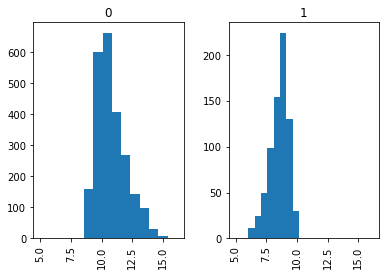

In [26]:
#descriptives of missing
df_all['obs'] = 1
df_all['nomiss_3'] = np.where(df_all[['retail','food_drugs','work']].isnull().any(axis=1),0,1)
df_all['consecutive_days_nomiss_3'] = df_all.groupby(['FIPS','nomiss_3'])['obs'].transform(sum)
df_all['max_days'] = np.where(df_all['consecutive_days_nomiss_3'] == df_all['consecutive_days_nomiss_3'].max(),1,0)
df_all['ln_pop'] = np.log(df_all['POP_ESTIMATE_2018'])
df_all.drop_duplicates(['FIPS','max_days']).hist(column='ln_pop',by='max_days',sharex=True)

In [27]:
df_all[df_all['max_days']==1][['eased_state_sah_neighborall','eased_state_non_ess_neighborall','eased_state_lgb_neighborall','eased_state_bar_res_neighborall']].describe()

,eased_state_sah_neighborall,eased_state_non_ess_neighborall,eased_state_lgb_neighborall,eased_state_bar_res_neighborall
count,72922.000000,72922.000000,72922.000000,72922.000000
mean,0.085996,0.193865,0.060284,0.135131
std,0.280360,0.395327,0.238013,0.341865
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [28]:
df_all.columns.values

array(['Unnamed: 0', 'FIPS', 'date', 'device_count',
       'completely_home_device_count', 'part_time_work_behavior_devices',
       'full_time_work_behavior_devices', 'leaving_home',
       'pct_leaving_home', 'pct_social_distancing', 'county_x', 'state_x',
       'latitude', 'longitude', 'amount_land', 'population',
       'ln_population', 'perc_elderly', 'med_hh_income', 'per_cap_income',
       'perc_white', 'perc_african_american', 'perc_asian',
       'perc_native_american', 'perc_other_race', 'perc_employed',
       'perc_unemployed', 'perc_self_employed_not_own',
       'perc_self_employed_own', 'perc_unpaid_fam_workers',
       'perc_private_employees', 'perc_private_non_profit',
       'perc_govt_workers', 'state_abb_x', 'retail', 'food_drugs', 'park',
       'transit', 'work', 'homes', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018',
       'Births_2018', 'Deaths_2018', 'NATURAL_INC_2018',
       'INTERNATIONAL_MIG_2018', 'DOMESTIC_MIG_2018', 'NET_MIG_2018',
       'RESIDUAL_2018', '

In [29]:
df_all.shape
df_all.groupby(['FIPS','state_x','county_x']).agg({'cases':'sum','population':'max'}).to_csv('chk.csv')

In [30]:
df_all[~df_all['county_x'].isin(['Kings County','Queens County','New York County','Bronx County','Richmond County'])].shape

(312494, 558)

In [31]:
df_all['date'] = pd.to_datetime(df_all['date'],errors='coerce')
state_dumms = pd.get_dummies(df_all.state_abb_x)
states = state_dumms.columns.values
day_dumms = pd.get_dummies(df_all['date'].dt.date)
print(len(day_dumms.columns))
day_dumms.columns = ['day' + str(i) for i in list(range(0,len(day_dumms.columns)))]
days = day_dumms.columns.values
df_fin = pd.concat([df_all,state_dumms,day_dumms],axis=1)
df_fin = df_fin[df_fin['no_nyt_order']==0].copy()
df_fin = df_fin[~df_fin['county_x'].isin(['Kings County','Queens County','New York County','Bronx County','Richmond County'])].copy()
df_fin = df_fin[~df_fin['state_abb_x'].isin(['PR','HI','AK'])].copy()
df_fin['cases'] = df_fin['cases'].fillna(0)
df_fin['deaths'] = df_fin['deaths'].fillna(0)
df_fin['ln_cases'] = np.log(df_fin['cases']+1 )
df_fin['ln_deaths'] = np.log(df_fin['deaths']+1 )
df_fin['pct_social_distancing'] = df_fin['pct_social_distancing']*100
df_fin['pct_leaving_home'] = df_fin['pct_leaving_home']*100
df_fin = df_fin[(df_fin['state_abb_x']!="AK")|df_fin['state_abb_x']!="HI"].copy() 
df_fin.rename(columns={'Percent of adults with less than a high school diploma, 2014-18':'pct_less_hs',
       'Percent of adults with a high school diploma only, 2014-18':'pct_only_hs',
       "Percent of adults completing some college or associate's degree, 2014-18":'pct_some_co',
       "Percent of adults with a bachelor's degree or higher, 2014-18":'pct_has_co'}, inplace=True)
df_fin = df_fin.merge(usda,on=['FIPS'],how='left')
extra_controls = ['ln_total_stores','perc_pop_low_access15','pct_less_hs','pct_only_hs','pct_some_co','PCTPOVALL_2018']
df_fin['ln_pop_18'] = df_fin['POP_ESTIMATE_2018'].apply(np.log)
df_fin['ln_pop_density'] =  ((df_fin['population'] / df_fin['amount_land'])+1).apply(np.log)
df_fin['ln_income_18'] = df_fin['Median_Household_Income_2018'].apply(np.log)
df_fin['ln_income'] = df_fin['med_hh_income'].apply(np.log)
df_fin['ln_employed_18'] = df_fin['Employed_2018'].apply(np.log)
df_fin['ln_unemployed_18'] = df_fin['Unemployed_2018'].apply(np.log)
df_fin['ln_total_stores'] = df_fin['total_stores'].apply(np.log)
df_fin['obs'] = 1
df_fin = df_fin.dropna(subset= ['party'])
print(df_fin.shape)
df_fin['nomiss_3'] = np.where(df_fin[['pct_social_distancing','pct_leaving_home','work']].isnull().any(axis=1),0,1)
df_fin['consecutive_days_nomiss_3'] = df_fin.groupby(['FIPS','nomiss_3'])['obs'].transform(sum)
df_fin['max_days'] = np.where(df_fin['consecutive_days_nomiss_3'] == df_fin['consecutive_days_nomiss_3'].max(),1,0)
df_fin['googl'] = np.where(df_fin['work'].notnull(),1,0)
df_fin.sort_values(by=['FIPS','date'],inplace=True)

101


C:\Users\Noah\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


(312494, 726)


In [32]:
df_fin.to_csv('data/analysis_data_{}.csv'.format(str(datetime.now().date())))

In [33]:
df_fin.groupby(['obs']).agg({'date':'max','FIPS':'nunique'})

,date,FIPS
obs,,
1,2020-05-25,3094


In [26]:
df_fin.columns.values

array(['Unnamed: 0', 'FIPS', 'date', 'device_count',
       'completely_home_device_count', 'part_time_work_behavior_devices',
       'full_time_work_behavior_devices', 'leaving_home',
       'pct_leaving_home', 'pct_social_distancing', 'county_x', 'state_x',
       'latitude', 'longitude', 'amount_land', 'population',
       'ln_population', 'perc_elderly', 'med_hh_income', 'per_cap_income',
       'perc_white', 'perc_african_american', 'perc_asian',
       'perc_native_american', 'perc_other_race', 'perc_employed',
       'perc_unemployed', 'perc_self_employed_not_own',
       'perc_self_employed_own', 'perc_unpaid_fam_workers',
       'perc_private_employees', 'perc_private_non_profit',
       'perc_govt_workers', 'state_abb_x', 'retail', 'food_drugs', 'park',
       'transit', 'work', 'homes', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018',
       'Births_2018', 'Deaths_2018', 'NATURAL_INC_2018',
       'INTERNATIONAL_MIG_2018', 'DOMESTIC_MIG_2018', 'NET_MIG_2018',
       'RESIDUAL_2018', '

In [27]:
# set one
one = {'name':'one',
    'lhs':['pct_social_distancing','pct_leaving_home','work','retail'],
'rhs':[['post_nyt_sah_neighborall','post_nyt_sah'],['avg_post_nyt_sah_neighborall','post_nyt_sah'],['all_p_nyt_sah','eased_nyt_sah_neighborall','eased_nyt_sah']],
'controls':['vote_share_rep','ln_cases','ln_deaths','ln_income','ln_pop_density','perc_elderly','ln_population','perc_employed'] + list(days)[1:] + list(states)[1:],
'sample':['obs','googl']}

In [28]:
runs_1 = [one]

In [29]:
df_fin['ln_cases'].describe()

count    288114.000000
mean          1.570536
std           2.021961
min           0.000000
25%           0.000000
50%           0.693147
75%           2.772589
max          11.038416
Name: ln_cases, dtype: float64

In [30]:
# First Set
res = []
models = []
for r in runs_1:
    for x in r['rhs']:
        for y in r['lhs']:
            for s in r['sample']:
                vrs = x + r['controls'] + [y]
                vrs = [re.split(r'\*| \+ ',i.replace('C(','').replace(')','')) for i in vrs]
                vrs = list(itertools.chain.from_iterable(vrs))
                sam = df_fin[(df_fin[s]==1)&(df_fin[y].notnull())][vrs].copy()
                X = x + r['controls'] 
                strng = '{} ~ '.format(y) + ' + '.join([str(i) for i in X])
                print(sam[y].describe())
                mod = smf.ols(strng,data=sam)
                print(r['name'],s,y,x)
                fitted = mod.fit(cov_type='HC1', return_type='dataframe')
                res.extend([fitted])
                title = 'Sample={}\nLHS={}\nRHS={}'.format(s,y,x)
                models.extend([title])
                sam = None
results = summary_col(res,stars=True,float_format='%0.2f',
                  model_names=models,
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.2f}".format(x.rsquared),
                            'R2adj':lambda x: "{:.2f}".format(x.rsquared_adj),
                            'F-pval':lambda x: "{:.2f}".format(int(x.f_pvalue))})
pd.DataFrame(results.tables[0]).to_csv('models/neighbors_run_v2a.csv')

count    288114.000000
mean         33.511091
std           7.874028
min           1.342282
25%          27.650728
50%          32.941176
75%          38.869381
max         100.000000
Name: pct_social_distancing, dtype: float64
one obs pct_social_distancing ['post_nyt_sah_neighborall', 'post_nyt_sah']
count    230607.000000
mean         33.707125
std           7.623161
min          11.155378
25%          27.838828
50%          33.131313
75%          39.045336
max          67.512048
Name: pct_social_distancing, dtype: float64
one googl pct_social_distancing ['post_nyt_sah_neighborall', 'post_nyt_sah']
count    288114.000000
mean         70.341035
std           8.012819
min          17.241379
25%          64.847923
50%          70.707551
75%          76.351351
max          98.876404
Name: pct_leaving_home, dtype: float64
one obs pct_leaving_home ['post_nyt_sah_neighborall', 'post_nyt_sah']
count    230607.000000
mean         70.246057
std           7.944934
min          35.585899
25%    

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 153, but rank is 151
  'rank is %d' % (J, J_), ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 153, but rank is 150
  'rank is %d' % (J, J_), ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 153, but rank is 151
  'rank is %d' % (J, J_), ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 153, but rank is 150
  'rank is %d' % (J, J_), ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: Value